# Optimal estimation

Suppose we have the linear gauss observing system

$\begin{equation*}
 \begin{cases}
   X_t = a_t X_{t-1} + c_t + b_t V_t, t \in N, X_0 \sim N(0,1)\\
   Y_t = A_t X_t + C_t + B_t W_t
 \end{cases}
\end{equation*}$

Let`s impelement absolutely optimal filtration

Start:

$\hat{\pi_0}(x) = \pi_0(x)$

$\hat{X_0} = E[X_0 | Y_0] = \int_{-\infty}^{+∞} x \pi_0(x)dx$

Step:

Prediction:

$\widetilde{\pi}_t(x) = \int_{-∞}^{+∞} |{b_t}^{-1}| p_{V}({b_t}^{-1} \cdot (x-a_t(u))) \hat{\pi}_{t-1}(u)du$

Correction:

$\rho_t(x,y) = |{B_t}^{-1}|p_W({B_t}^{-1}(y-A_t(x))) \widetilde{\pi}_t(x)$

$\hat{\pi_t}(x) = \frac{\rho_t(x, Y_t)}{ \int_{-∞}^{+∞} \rho_t(u, Y_t)du} $

$\hat X_t = \frac{1}{\int_{-∞}^{+∞} \rho_t (v, Y_t)dv} \int_{-∞}^{+∞} u \rho_t (u, Y_t)du$



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from scipy import integrate
from tqdm.notebook import tqdm

In [35]:
class LinearGaussianSystem:
    def __init__(self, a, b, c, A, B, C, p_0, p_v, p_w):
        self.a = a
        self.b = b
        self.c = c
        self.A = A
        self.B = B
        self.C = C
        self.p_0 = p_0
        self.p_v = p_v
        self.p_w = p_w

        self.x_0 = self.p_0.rvs(size = 1)[0]
        self.pi_0 = self.p_0

        self.time_list = []
        self.x_list = []
        self.y_list = []
        self.est_x_list = []

    def simulate_x(self, start = 0, end = 100, step = 1):
        prev_val = None
        curr_val = None

        for i in range(start, end + step, step):
            self.time_list.append(i)
            prev_val = curr_val
            if i == 0:
                curr_val = self.x_0
            else:
                V = self.p_v.rvs(size = 1)[0]
                curr_val = self.a * prev_val + self.c + self.b * V
            self.x_list.append(curr_val)
        return self.x_list

    def simulate_y(self):
        if len(self.x_list) == 0:
                print('WARNING: Probably You didn\'t simulate X')
                return []

        temp_var = self.A * np.array(self.x_list) + self.C + self.B * self.p_w.rvs(
             size = len(self.x_list))[0]
        self.y_list = list(temp_var)
        return self.y_list


    def estimate_x(self, h = 0.01):
        prev_pi_arr = None
        curr_pi_arr = None

        start = -1
        end = 2
        eps = 1e-5
        arr_x = np.linspace(start=start, stop=end, num=int((end - start)/h))

        def func_to_array(foo, start, end, h):
            return list(map(foo, arr_x))

        def array_to_func(arr, x, start, end, h):
            i = int( (x - start) / h )
            return arr[i]

        for i in tqdm(range(len(self.x_list))):
            prev_pi_arr = curr_pi_arr
            if i == 0:
                curr_pi = self.pi_0.pdf
                f = lambda x: x * curr_pi(x)
                value = integrate.quad(f, -1, 2, epsabs=h)[0]
                self.est_x_list.append(value)
            else:
                prev_pi = lambda x: array_to_func(prev_pi_arr, x, start, end, h)
                prev_pi_temp = prev_pi

                def f(u, x):
                    return abs(self.b**(-1)) * self.p_v.pdf(self.b**(-1) * (x - self.a) ) * prev_pi_temp(u)
                self.prev_pi_temp = prev_pi_temp

                prev_pi = lambda x: integrate.quad(lambda u: f(u, x), -1, 2, epsabs=h)[0]
                rho = lambda x: abs(self.B**(-1)) * self.p_w.pdf(self.B**(-1) * (self.y_list[i] - self.A)) * prev_pi(x)
                rho_min = np.min([eps + rho(x) for x in np.linspace(-1, 2, num=int(2/h))])
                rho_normalized = lambda x: rho(x) / rho_min

                curr_pi = lambda x: rho_normalized(x) / integrate.quad(rho_normalized, -1, 2, epsabs=h)[0]


                t_frst_int = integrate.quad(rho_normalized, -1, 1, epsabs=h)[0]
                t_sec_int = integrate.quad(lambda x: x * rho_normalized(x), -1, 1, epsabs=h)[0]
                value = 1 / (t_frst_int + eps) * t_sec_int

                self.est_x_list.append(value)
            curr_pi_arr = func_to_array(curr_pi, start, end, h)

        return self.est_x_list


In [33]:
a = 1
b = 0.5
c = 0
A = 1
B = 1
C = 0
p_0 = ss.norm()
p_v = ss.norm(loc = 1)
p_w = ss.norm(loc = 1)

LGS = LinearGaussianSystem(a = a, b = b, c = c, A = A, B = B, C = C, p_0 = p_0, p_v = p_v, p_w = p_w)
x = LGS.simulate_x(step=2)
y = LGS.simulate_y()
print(LGS.x_list)
x_est = LGS.estimate_x(h=0.1)

[-0.7845841007322466, 0.6506312408750058, 0.9900637391900293, 1.6145620556158726, 1.3188797960411731, 1.56855523438405, 2.6039995092352006, 3.2355096247874506, 4.234428526100933, 4.8722651486609525, 6.639961116724002, 6.687085028915575, 7.002186504235312, 7.900421132885326, 8.249763930028296, 8.378041958147048, 8.16451287345569, 8.852537073268909, 7.805748031668124, 7.460276124351517, 7.398744682436391, 7.253628109911476, 6.870083421541948, 7.042218916347439, 7.837444184275431, 8.614880662558658, 8.05051884324077, 8.645957455752647, 8.907828367097547, 8.679350011949342, 9.317808668061677, 10.949772276853748, 11.133520725416346, 11.653359541112927, 12.340843811808714, 13.294638357059684, 14.07516650833064, 14.835440509143217, 15.70566125733448, 17.25981621279105, 17.78037104375621, 18.35206476582018, 17.938357445455384, 18.066249241366798, 17.767643536295456, 18.334576593684687, 19.628495015511174, 20.6918815818303, 21.685675064102874, 22.04920649316051, 21.88731020680745]


  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [34]:
LGS.est_x_list

[0.1879797580059553,
 0.7374356670027595,
 0.7362128477266888,
 0.7362257815345198,
 0.7362256207814445,
 0.7362256858632216]

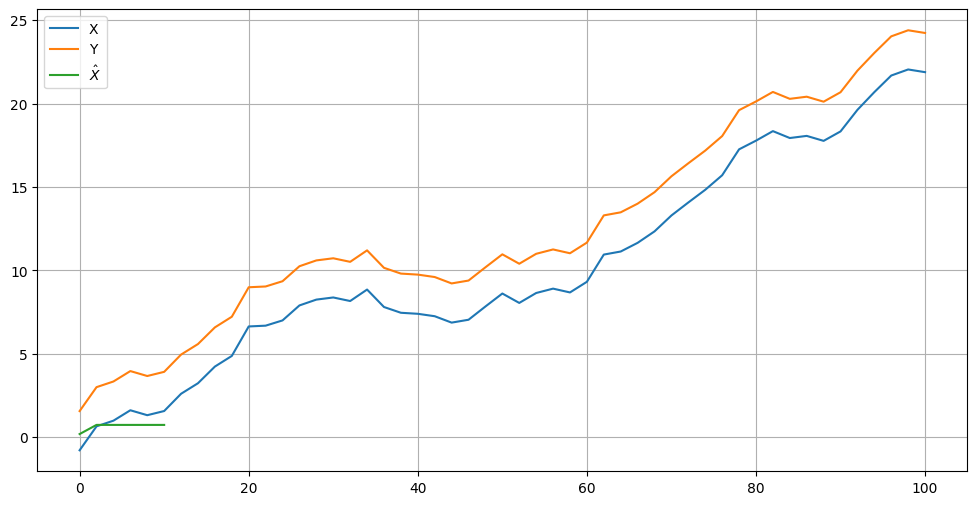

In [40]:
plt.figure(figsize=(12, 6))
plt.grid(True)

t = LGS.time_list
plt.plot(t, x, label='X')
plt.plot(t, y, label='Y')
plt.plot(t[:len(LGS.est_x_list)], LGS.est_x_list, label="$\hat{X}$")
plt.legend()

**Results**

This algorihm is really slow and you should not use it in real life

Unfortunately naive realization could not work, because you will get error with too big stek of recursion: it makes more then 999 recursion depth to calculate only second estimation of X

So, here we used a trick to make function to array by it's values and back.
Also we used trick to add some $\epsilon = \textit{1e-5}$ in divide

And trick to normalize rho - so, computer didn't work with near zero values
